In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.optimizers import Adam

from skimage.transform import resize

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow 

import pandas as pd
import keras
import random
import math
import seaborn as sns
import nibabel as nib
import numpy as np
import skimage.transform as skTrans

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [20]:
# data=[]
# labels=[]
# random.seed(42)
# imagePaths = sorted(list(os.listdir("studies/data/")))
# random.shuffle(imagePaths)
# print(imagePaths)

# for img in imagePaths:
#     path=sorted(list(os.listdir("studies/data/"+img)))
#     for i in path:
#         img_path = "studies/data/"+str(img)+'/'+str(i)
#         image = nib.load(img_path)
#         image_d = image.get_fdata()
#         queue = image.dataobj.shape[2]
#         img_arr = skTrans.resize(image_d, (128, 128, queue), order=1, preserve_range=True)
#         img_arrs = img_arr[:,:,queue//2-3:queue//2]
#         data.append(img_arrs)
#         l = label = img
#         labels.append(l[-1])

data=[]
imagePaths = sorted(list(os.listdir("studies/change/")))
print(imagePaths)
for img in imagePaths:
    path=sorted(list(os.listdir("studies/change/"+img)))
    for i in path:
        img_path = "studies/change/"+str(img)+'/'+str(i)
        image = np.load(img_path)
#         image_d = image.get_fdata()
#         queue = image.dataobj.shape[2]
#         img_arr = skTrans.resize(image_d, (128, 128, queue), order=1, preserve_range=True)
#         img_arrs = img_arr[:,:,queue//2]      
        img_arrs = resize(image, output_shape = (128, 128, 3), preserve_range=True)
        if(np.min(img_arrs) == 0) :
            img_arrs = img_arrs/255
        else :
            img_arrs = img_arrs/2048
            img_arrs = img_arrs + 1
            img_arrs = img_arrs/2
        data.append((img_arrs, int(img[-1])))
        

['CT-0', 'CT-1', 'CT-2', 'CT-3']


In [21]:
# data = np.array(data, dtype="float32") / 255.0
# labels = np.array(labels)
# mlb = LabelBinarizer()
# labels = mlb.fit_transform(labels)
# print(labels[0])

random.seed(0)
random.shuffle(data)
image_data = []
classes = []
for d in data:
    image_data.append(d[0])
    classes.append(d[1])
image_data = np.array(image_data, dtype="float32") / 255.0
classes = np.array(classes)
mlb = LabelBinarizer()
classes = mlb.fit_transform(classes)

In [22]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(874, 128, 128, 3, 1) (219, 128, 128, 3, 1)


In [23]:
import torch
import torch.nn as nn

In [24]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [25]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
        block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
        block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
        block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
        block, layers[3], intermediate_channels=512, stride=2
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [26]:
def ResNet101(img_channel=3, num_classes=2):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


In [27]:
# base_model = ResNet101(img_channel=3, num_classes=2)
# # y = net(torch.randn(4, 3, 256, 256)).to(device)
# x = base_model.input

from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import AvgPool2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

base_model = ResNet50(input_shape=(128, 128, 3), include_top=False, weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [28]:
(xtrain,xtest,ytrain,ytest)=train_test_split(image_data,classes,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=100,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

(874, 128, 128, 3, 1) (219, 128, 128, 3, 1)


ValueError: Input to `.fit()` should have rank 4. Got array with shape: (874, 128, 128, 3, 1)

In [26]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 114 	accurately-predicted-data: 37 	 wrongly-predicted-data:  77
Accuracy: 32.456 %


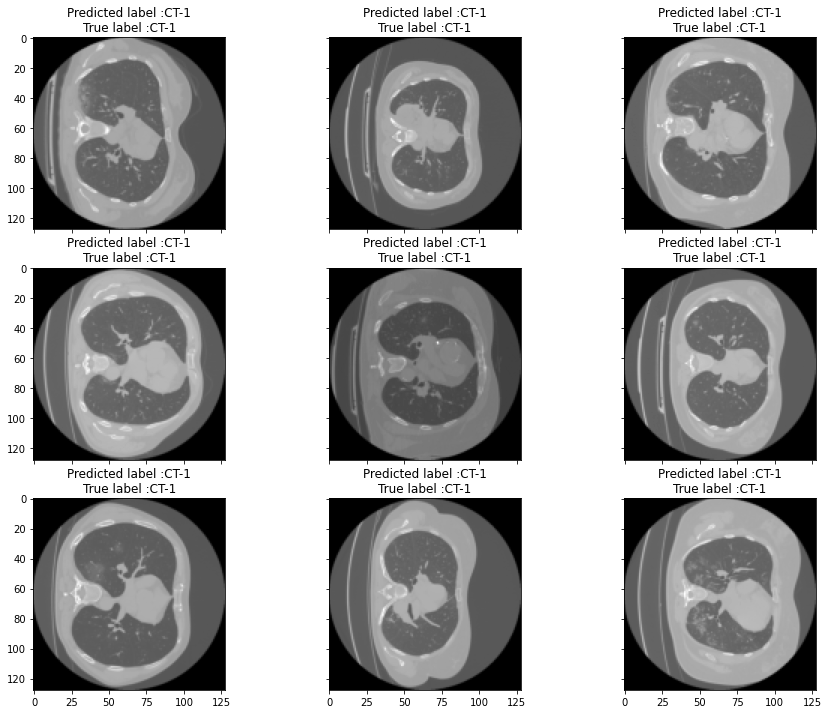

In [14]:
label= ['CT-0', 'CT-1', 'CT-2', 'CT-3', 'CT-4']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]][:,:,0], cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

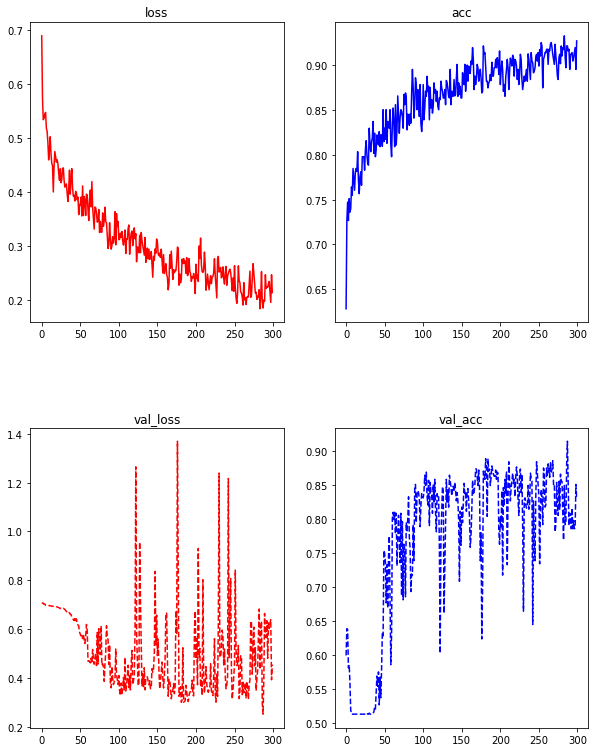

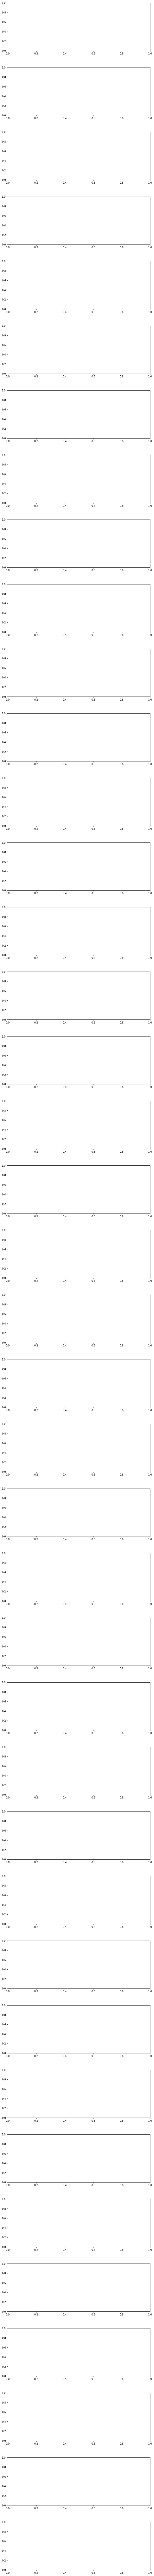

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')
    
preds = model.predict(xtrain)

fig1, ax1 = plt.subplots(40, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

# for i in range(40):
#     ax1[i].imshow(xtrain[i].squeeze())
#     ax1[i].title.set_text(str(preds[i]))